# Enterprise Spend Analytics & Reporting (AmEx-Style)

## Business Objective
Analyze enterprise transaction-level spend data to track performance KPIs, identify spend drivers across suppliers, categories, and regions, and enable data-driven decision-making for leadership.

In [27]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

## Data Preparation & Feature Engineering


In [3]:
np.random.seed(42)
n = 2000
data = {
    "transaction_id": range(1, n+1),
    "transaction_date": pd.date_range(start="2024-01-01", periods=n, freq="D"),
    "supplier_name": np.random.choice(
        ["Amazon", "TCS", "Infosys", "Microsoft", "Google", "Accenture", "IBM"], n
    ),
    "category": np.random.choice(
        ["Travel", "IT Services", "Marketing", "Operations"], n
    ),
    "region": np.random.choice(
        ["NA", "EMEA", "APAC"], n
    ),
    "amount": np.round(np.random.uniform(100, 5000), 2),
    "payment_type": np.random.choice(
        ["Corporate Card", "Bank Transfer"], n
    ),
    "business_unit": np.random.choice(
        ["Sales", "Finance", "Operations"], n
    )
}
df = pd.DataFrame(data)
df.head()

,transaction_id,transaction_date,supplier_name,category,region,amount,payment_type,business_unit
0,1,2024-01-01,IBM,Operations,NA,442.02,Bank Transfer,Finance
1,2,2024-01-02,Microsoft,Travel,APAC,442.02,Corporate Card,Operations
2,3,2024-01-03,Google,Operations,NA,442.02,Corporate Card,Finance
3,4,2024-01-04,IBM,IT Services,NA,442.02,Bank Transfer,Finance
4,5,2024-01-05,Infosys,Travel,NA,442.02,Corporate Card,Operations


## SQL-Based Spend Analysis


In [4]:
conn = sqlite3.connect("spend.db")
df.to_sql("enterprise_spend", conn, if_exists="replace", index=False)

2000

In [5]:
query = """
SELECT category,
       ROUND(SUM(amount), 2) AS total_spend
FROM enterprise_spend
GROUP BY category
ORDER BY total_spend DESC;
"""

pd.read_sql(query, conn)

,category,total_spend
0,Operations,232502.52
1,IT Services,228082.32
2,Travel,219683.94
3,Marketing,203771.22


In [6]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["year"] = df["transaction_date"].dt.year
df["month"] = df["transaction_date"].dt.month
df["month_name"] = df["transaction_date"].dt.strftime("%b")

In [7]:
df.to_sql("enterprise_spend", conn, if_exists="replace", index=False)

2000

In [8]:
query = """
SELECT year,
       month,
       ROUND(SUM(amount), 2) AS monthly_spend
FROM enterprise_spend
GROUP BY year, month
ORDER BY year, month;
"""

monthly_spend = pd.read_sql(query, conn)
monthly_spend

,year,month,monthly_spend
0,2024,1,13702.62
1,2024,2,12818.58
2,2024,3,13702.62
3,2024,4,13260.60
4,2024,5,13702.62
...,...,...,...
61,2029,2,12376.56
62,2029,3,13702.62
63,2029,4,13260.60
64,2029,5,13702.62


In [10]:
monthly_spend["mom_growth_pct"] = (
    monthly_spend["monthly_spend"].pct_change() * 100
).round(2)
monthly_spend

,year,month,monthly_spend,mom_growth_pct
0,2024,1,13702.62,NaN
1,2024,2,12818.58,-6.45
2,2024,3,13702.62,6.90
3,2024,4,13260.60,-3.23
4,2024,5,13702.62,3.33
...,...,...,...,...
61,2029,2,12376.56,-9.68
62,2029,3,13702.62,10.71
63,2029,4,13260.60,-3.23
64,2029,5,13702.62,3.33


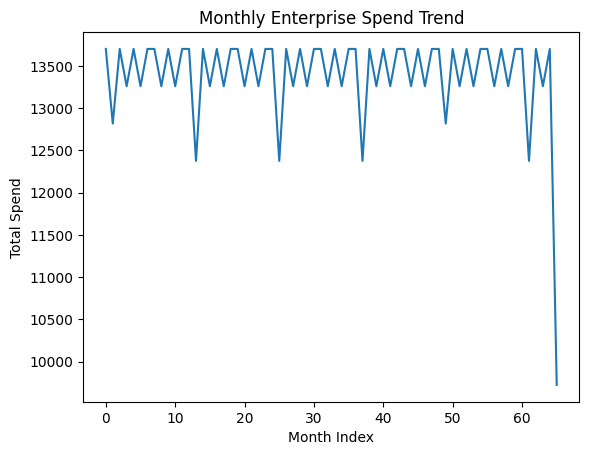

In [11]:
plt.figure()
plt.plot(monthly_spend["monthly_spend"])
plt.title("Monthly Enterprise Spend Trend")
plt.xlabel("Month Index")
plt.ylabel("Total Spend")
plt.show()

In [12]:
query = """
SELECT supplier_name,
       ROUND(SUM(amount), 2) AS supplier_spend
FROM enterprise_spend
GROUP BY supplier_name
ORDER BY supplier_spend DESC;
"""

supplier_spend = pd.read_sql(query, conn)
supplier_spend

,supplier_name,supplier_spend
0,Amazon,135700.14
1,Google,130395.90
2,TCS,124649.64
3,IBM,124207.62
4,Accenture,123765.60
5,Infosys,123323.58
6,Microsoft,121997.52


In [14]:
supplier_spend["cumulative_pct"] = (
    supplier_spend["supplier_spend"].cumsum() /
    supplier_spend["supplier_spend"].sum() * 100
).round(2)
supplier_spend

,supplier_name,supplier_spend,cumulative_pct
0,Amazon,135700.14,15.35
1,Google,130395.90,30.10
2,TCS,124649.64,44.20
3,IBM,124207.62,58.25
4,Accenture,123765.60,72.25
5,Infosys,123323.58,86.20
6,Microsoft,121997.52,100.00


In [15]:
query = """
SELECT category,
       ROUND(SUM(amount), 2) AS total_spend,
       ROUND(AVG(amount), 2) AS avg_transaction_value,
       COUNT(*) AS transaction_count
FROM enterprise_spend
GROUP BY category
ORDER BY total_spend DESC;
"""

category_kpi = pd.read_sql(query, conn)
category_kpi

,category,total_spend,avg_transaction_value,transaction_count
0,Operations,232502.52,442.02,526
1,IT Services,228082.32,442.02,516
2,Travel,219683.94,442.02,497
3,Marketing,203771.22,442.02,461


In [16]:
query = """
SELECT region,
       ROUND(SUM(amount), 2) AS total_spend,
       COUNT(*) AS transaction_count
FROM enterprise_spend
GROUP BY region
ORDER BY total_spend DESC;
"""

region_kpi = pd.read_sql(query, conn)
region_kpi

,region,total_spend,transaction_count
0,NA,309414.00,700
1,APAC,298805.52,676
2,EMEA,275820.48,624


In [17]:
query = """
SELECT category,
       region,
       ROUND(SUM(amount), 2) AS total_spend
FROM enterprise_spend
GROUP BY category, region
ORDER BY category, region;
"""

category_region = pd.read_sql(query, conn)
category_region

,category,region,total_spend
0,IT Services,APAC,81773.70
1,IT Services,EMEA,72491.28
2,IT Services,NA,73817.34
3,Marketing,APAC,68513.10
4,Marketing,EMEA,63208.86
5,Marketing,NA,72049.26
6,Operations,APAC,78679.56
7,Operations,EMEA,74701.38
8,Operations,NA,79121.58
9,Travel,APAC,69839.16


## Key Performance Indicators (KPIs)


In [19]:
category_kpi.to_csv("category_kpi.csv", index=False)
region_kpi.to_csv("region_kpi.csv", index=False)
supplier_spend.to_csv("supplier_spend.csv", index=False)
monthly_spend.to_csv("monthly_spend.csv", index=False)
category_region.to_csv("category_region.csv", index=False)

## Executive Dashboards & Visual Insights


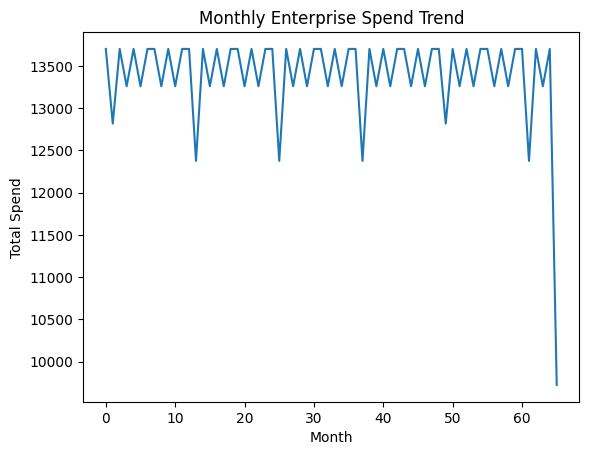

In [22]:
plt.figure()
plt.plot(monthly_spend["monthly_spend"])
plt.title("Monthly Enterprise Spend Trend")
plt.xlabel("Month")
plt.ylabel("Total Spend")
plt.show()

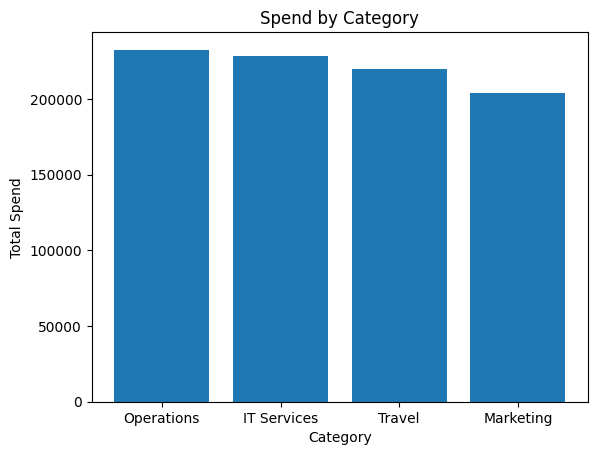

In [23]:
plt.figure()
plt.bar(category_kpi["category"], category_kpi["total_spend"])
plt.title("Spend by Category")
plt.xlabel("Category")
plt.ylabel("Total Spend")
plt.show()

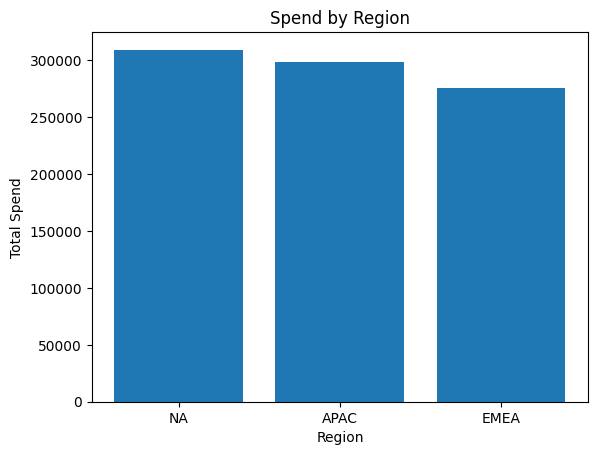

In [24]:
plt.figure()
plt.bar(region_kpi["region"], region_kpi["total_spend"])
plt.title("Spend by Region")
plt.xlabel("Region")
plt.ylabel("Total Spend")
plt.show()

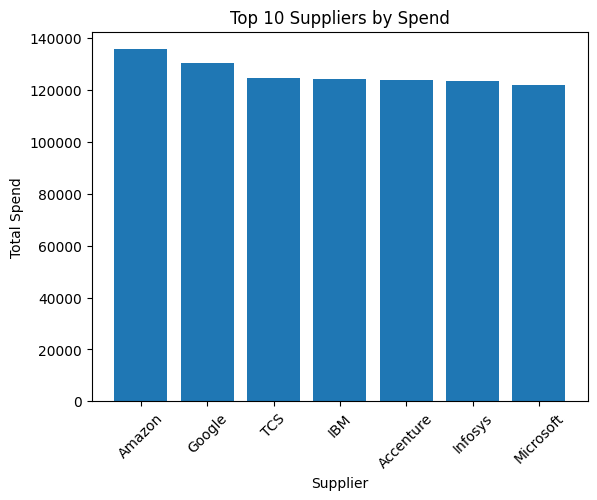

In [25]:
top_suppliers = supplier_spend.head(10)
plt.figure()
plt.bar(top_suppliers["supplier_name"], top_suppliers["supplier_spend"])
plt.title("Top 10 Suppliers by Spend")
plt.xlabel("Supplier")
plt.ylabel("Total Spend")
plt.xticks(rotation=45)
plt.show()

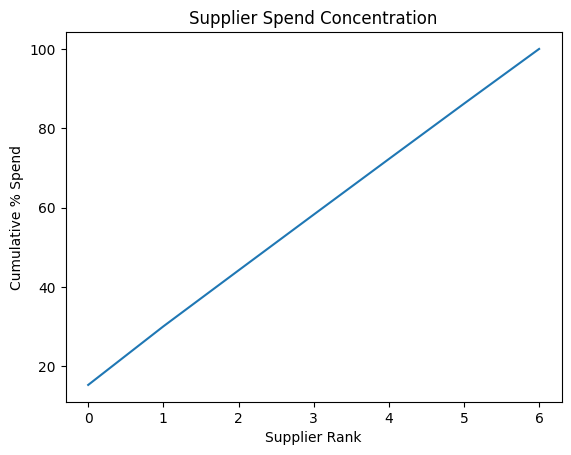

In [26]:
plt.figure()
plt.plot(supplier_spend["cumulative_pct"])
plt.title("Supplier Spend Concentration")
plt.xlabel("Supplier Rank")
plt.ylabel("Cumulative % Spend")
plt.show()